In [1]:
# %pip install kagglehub --quiet
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import sklearn

Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the data

This script downloads the Animals10 dataset and organizes it into a flat directory structure. It renames the Italian class folder names to English using a translation dictionary. Finally, it creates a Pandas DataFrame with image file paths and their corresponding labels for training.

In [17]:
def download_data():
    path = kagglehub.dataset_download("alessiocorrado99/animals10")

    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
    }

    os.makedirs("./data", exist_ok=True)
    shutil.move(path, "./data")
    for directory in os.listdir("./data/2/raw-img"):
        full_path = os.path.join("./data/2/raw-img", directory)
        if os.path.isdir(full_path):
            shutil.move(full_path, "./data")
    shutil.rmtree("./data/2")

    for folder in os.listdir("./data"):
        full_path = os.path.join("./data", folder)
        if os.path.isdir(full_path):
            new_folder_name = translate.get(folder, folder)
            new_full_path = os.path.join("./data", new_folder_name)
            if new_full_path != full_path:
                os.rename(full_path, new_full_path)

    print("Dataset downloaded and organized in './data' directory.")

def load_meta_data():
    file_names = []
    labels = []

    for folder in os.listdir("./data"):
        for file in os.listdir(os.path.join("./data", folder)):
            full_path = os.path.join("./data", folder, file)
            if os.path.isfile(full_path):
                file_names.append(full_path)
                labels.append(folder)

    meta_data = pd.DataFrame({
        'file_path': file_names,
        'label': labels
    })
    meta_data['label'] = meta_data['label'].astype('category')
    return sklearn.model_selection.train_test_split(meta_data, test_size=0.2, random_state=42, stratify=meta_data['label'])

In [19]:
train_set, test_set = load_meta_data()
train_set.head(10)

,file_path,label
10492,./data\dog\OIP-Fy6X3QdDD2GICos_g-CkygHaHa.jpeg,dog
15065,./data\horse\OIP--Hoe5PVuFl7QUqfg5SYNWwHaFj.jpeg,horse
668,./data\butterfly\OIP-6cpoMjN1R_lgziI9Lnz1UwHaE...,butterfly
6428,./data\chicken\OIP-USImzKVLQ3nw2xhhmri-2wHaFj....,chicken
17400,./data\horse\OIP-x1dmwXyO7sHratpL_SI8VQHaFC.jpeg,horse
23538,./data\spider\OIP-UzxfkKkYu_VJW_YXXJrlDwHaH2.jpeg,spider
6453,./data\chicken\OIP-v02hj9zYnxBIs1lfH-7UbgHaFj....,chicken
7550,./data\cow\OIP-fclqGfYrRH1j7ESfpmATMQHaGw.jpeg,cow
13634,./data\elephant\e834b20f28fd003ed1584d05fb1d4e...,elephant
13622,./data\elephant\e831b4082cf1013ed1584d05fb1d4e...,elephant


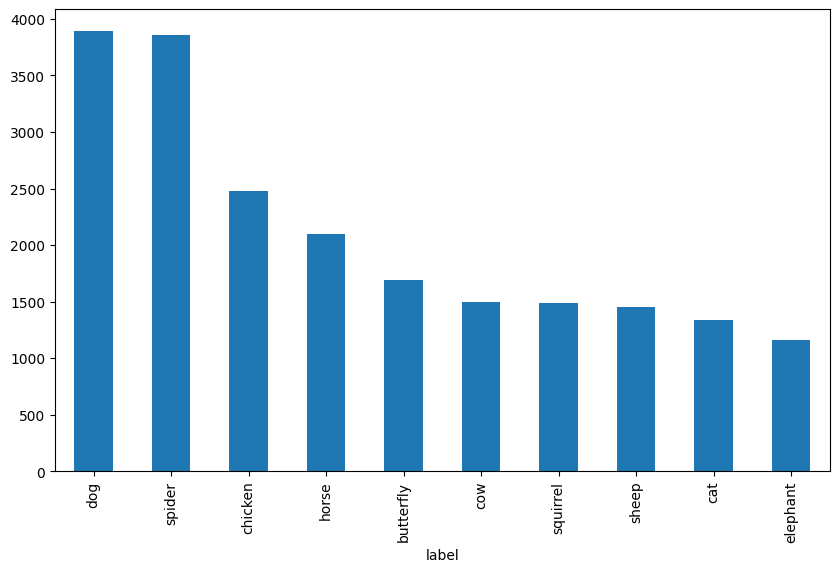

In [20]:
train_set["label"].value_counts().plot(kind='bar', figsize=(10, 6));

In [29]:
def create_data_generators(train_set, test_set, img_size=(300, 300), batch_size=32):
    def pad_and_rescale(image):
        image = tf.image.resize_with_pad(image, target_height=img_size[0], target_width=img_size[1])
        image = image / 255.0
        return image
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    return train_generator, test_generator

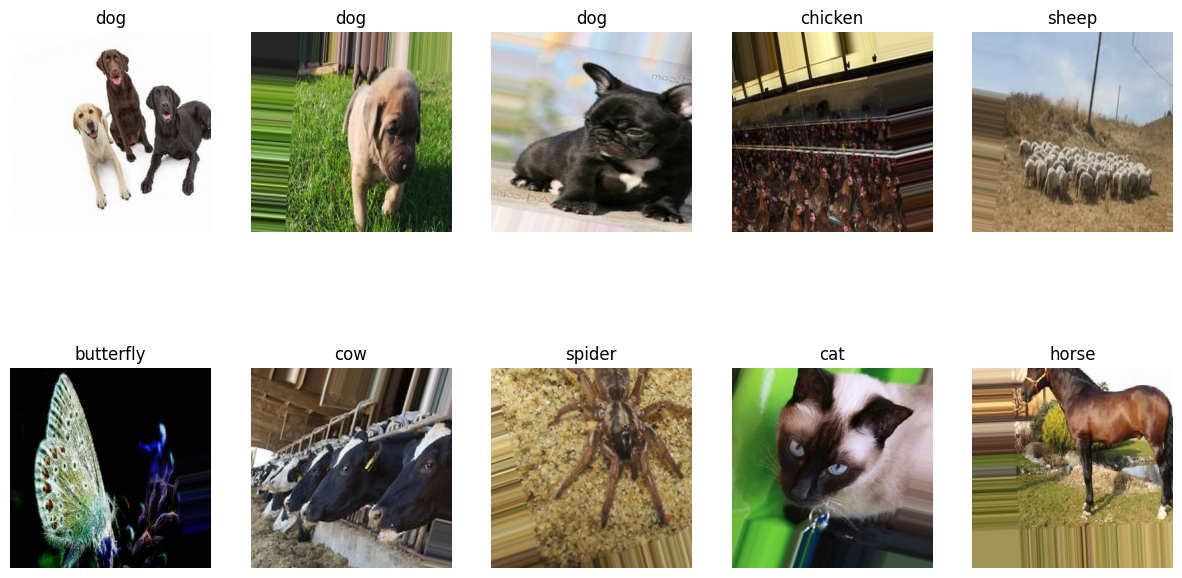

In [ ]:
plt.figure(figsize=(15, 8))
for i, (img, label) in enumerate(zip(train_generator[0][0], train_generator[0][1])):
    if i >= 10:
        break
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    plt.title(class_names[label.argmax()])
    plt.axis('off')

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\Colea\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │     7,200,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,200,906 (27.47 MB)

 Trainable params: 7,200,906 (27.47 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
train_generator, test_generator = create_data_generators(train_set, test_set, img_size=(300, 300), batch_size=32)

Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [1]:
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
    ]
)

NameError: name 'model' is not defined

In [39]:
predictions = model.predict(test_generator, verbose=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 45s 272ms/step


In [45]:
for i in range(10):
    for x in predictions[i]:
        print(f"Prediction {i+1}: {x * 100:.2f}%")
    print("\n" + "="*50 + "\n")

Prediction 1: 7.61%
Prediction 1: 0.33%
Prediction 1: 4.28%
Prediction 1: 0.01%
Prediction 1: 0.03%
Prediction 1: 0.06%
Prediction 1: 0.05%
Prediction 1: 0.07%
Prediction 1: 87.54%
Prediction 1: 0.02%


Prediction 2: 3.21%
Prediction 2: 3.25%
Prediction 2: 7.78%
Prediction 2: 1.95%
Prediction 2: 15.56%
Prediction 2: 1.54%
Prediction 2: 7.06%
Prediction 2: 0.57%
Prediction 2: 57.37%
Prediction 2: 1.71%


Prediction 3: 68.57%
Prediction 3: 0.03%
Prediction 3: 0.31%
Prediction 3: 0.00%
Prediction 3: 0.09%
Prediction 3: 0.00%
Prediction 3: 0.26%
Prediction 3: 0.00%
Prediction 3: 30.73%
Prediction 3: 0.00%


Prediction 4: 1.76%
Prediction 4: 17.19%
Prediction 4: 5.46%
Prediction 4: 0.24%
Prediction 4: 5.13%
Prediction 4: 1.56%
Prediction 4: 0.68%
Prediction 4: 2.33%
Prediction 4: 54.63%
Prediction 4: 11.03%


Prediction 5: 15.43%
Prediction 5: 0.36%
Prediction 5: 0.88%
Prediction 5: 0.02%
Prediction 5: 0.15%
Prediction 5: 0.07%
Prediction 5: 0.12%
Prediction 5: 0.01%
Prediction 5: 82.01%
Pr

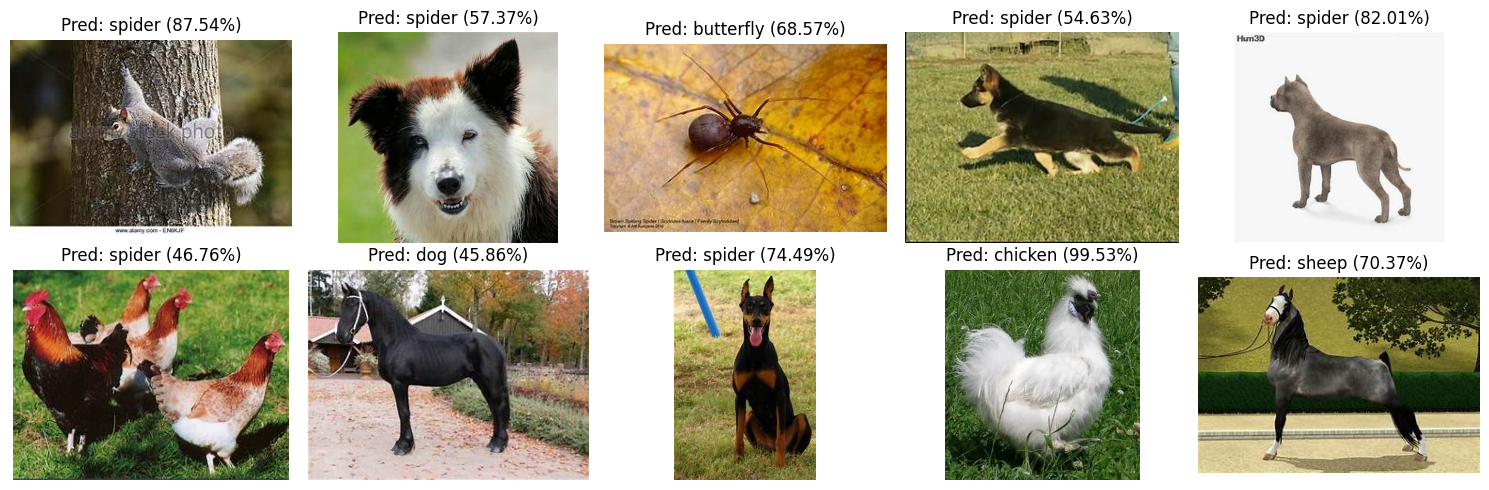

In [52]:
import matplotlib.image as mpimg
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[np.argmax(predictions[i])]} ({predictions[i][np.argmax(predictions[i])]*100:.2f}%)")
plt.tight_layout()

- Hilariously bad its basically just guessing that it is always going to be a spider, but on the actual spider it thinks it is going to be a butterfly.
- The percentage values is the confidence value so top right dog with a prediction of spider 82.01% means that the model is 82.01% certain that it is a spider.
- definitely some modifications we need to make to the model.